# 請結合前面的知識與程式碼，比較不同的 optimizer 與 learning rate 組合對訓練的結果與影響
### 常見的 optimizer 包含
* SGD
* RMSprop
* AdaGrad
* Adam

In [10]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [11]:
train, test = keras.datasets.cifar10.load_data()

In [12]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [13]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [14]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128, 64 , 64, 32]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model
    
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
hidden_layer4 (Dense)        (None, 64)                8256      
_________________________________________________________________
hidden_layer5 (Dense)        (None, 64)                4160      
_________________________________________________________________
hidden_layer6 (Dense)        (None, 32)                2080

In [15]:
## 超參數設定
"""
Set your required experiment parameters
"""
LEARNING_RATE = [1e-3 ,1e-5 ]
EPOCHS = 100
BATCH_SIZE = 256
MOMENTUM = 0.95

SGD = keras.optimizers.SGD( momentum=MOMENTUM)
RMSprop = keras.optimizers.RMSprop()
Adagrad = keras.optimizers.Adagrad()
Adam = keras.optimizers.Adam()

optimizers = {"SGD":SGD,"RMSprop":RMSprop,"Adagrad":Adagrad,"Adam":Adam}

In [16]:
results = {}
"""
建立你的訓練與實驗迴圈並蒐集資料
"""
for key, opt in optimizers.items():
    for lr in LEARNING_RATE:
        keras.backend.clear_session() # 把舊的 Graph 清掉
        print("Experiment with LR = %.6f and  opt = %s" %(lr,key))
        model = build_mlp(input_shape=x_train.shape[1:])
        model.summary()
        opt.LEARNING_RATE = lr
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=opt)

        model.fit(x_train, y_train, 
                epochs=EPOCHS, 
                batch_size=BATCH_SIZE, 
                validation_data=(x_test, y_test), 
                shuffle=True)
        
        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["accuracy"]
        valid_acc = model.history.history["val_accuracy"]
        
        exp_name_tag = "opt = %s >>> exp-lr-%s" %(str(lr),key)
        results[exp_name_tag] = {'train-loss': train_loss,
                                'valid-loss': valid_loss,
                                'train-acc': train_acc,
                                'valid-acc': valid_acc}



Experiment with LR = 0.001000 and  opt = SGD
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
hidden_layer4 (Dense)        (None, 64)                8256      
_________________________________________________________________
hidden_layer5 (Dense)        (None, 64)                4160      
_________________________________________________________________
hidden_layer6 

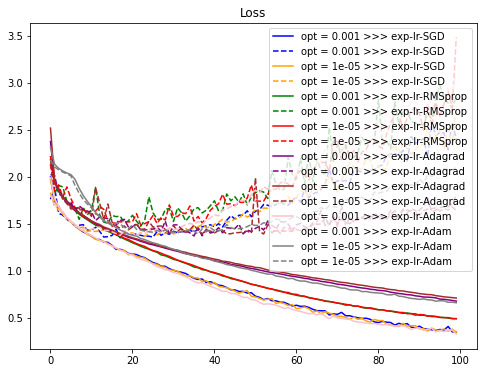

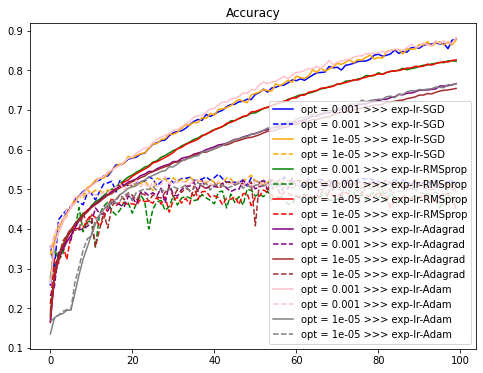

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

"""
將實驗結果繪出
"""
color_bar = ["Blue", "Orange", "Green", "Red", "Purple", "Brown" ,"pink" , "gray"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()